# Setup

In [7]:
import warnings
warnings.filterwarnings('ignore') #beware

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    KBinsDiscretizer, 
    FunctionTransformer,
    MinMaxScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    validation_curve, 
    KFold,
)
from sklearn.metrics import (
    plot_confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    f1_score,
    classification_report,
)

# Load data

In [8]:
app_train = pd.read_csv('data/application_train.csv')

In [9]:
for column in app_train.columns:
    print(column)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

# Load other tables data

In [4]:
%run ./lennard/bureau_data_prep.ipynb
# final df name: bureau_reduced

Percentage of rows empty: 

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64
Percentage of rows empty: 

SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64


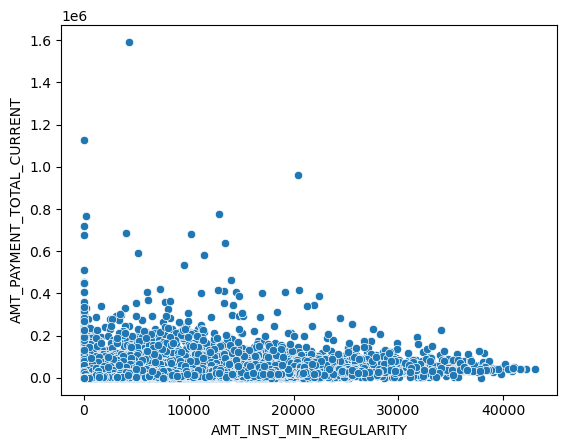

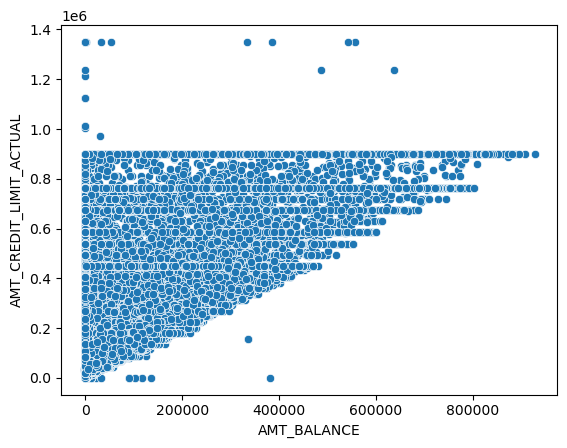

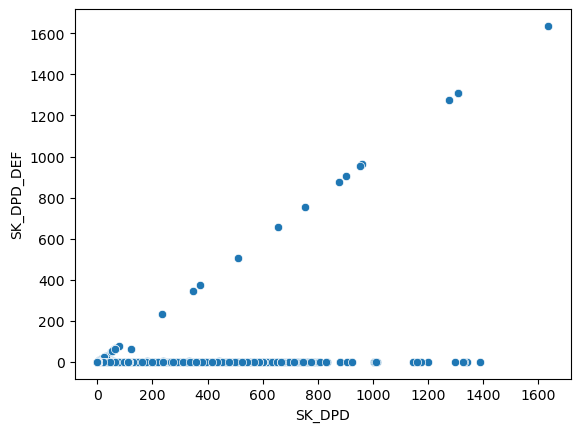

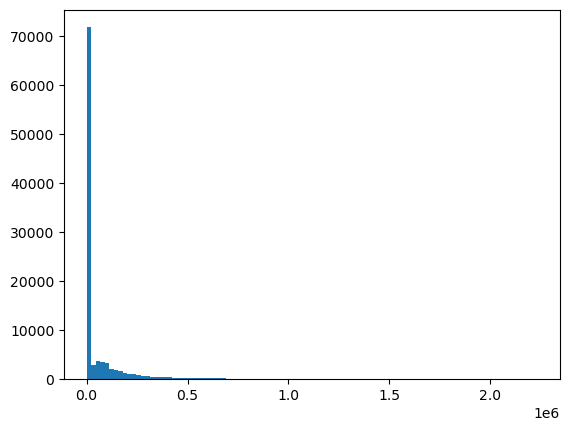

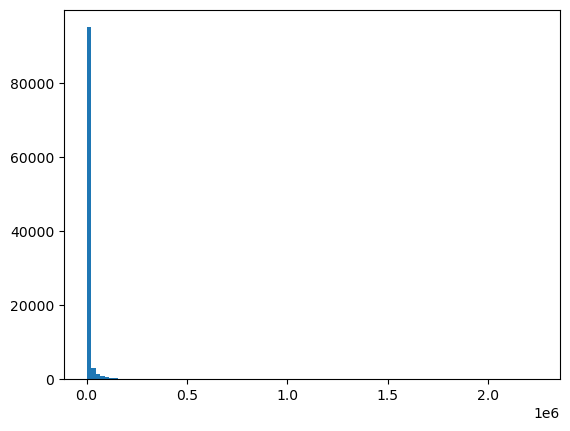

SK_DPD                  0
AMT_RECEIVABLE_RAT      0
MIN_INST_PAYMENT_RAT    0
dtype: int64
 
(101989, 3)


In [5]:
%run ./credit_card_bora.ipynb
# final df name: df_ccard_agg

# Join data files

### Add bureau data

In [10]:
app_train = app_train.merge(bureau_reduced, on = "SK_ID_CURR", how = "left")

NameError: name 'bureau_reduced' is not defined

### Add credit card data

In [7]:
app_train = app_train.merge(df_ccard_agg, on = "SK_ID_CURR", how = "left")

In [30]:
app_train.isna().sum()

SK_ID_CURR                                 0
TARGET                                     0
NAME_CONTRACT_TYPE                         0
CODE_GENDER                                0
FLAG_OWN_CAR                               0
                                       ...  
issues_last_year                      217456
share_of_income_generating_credits    217456
SK_DPD                                222065
AMT_RECEIVABLE_RAT                    222065
MIN_INST_PAYMENT_RAT                  222065
Length: 136, dtype: int64

# Split data

In [167]:
X = app_train
y = app_train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    random_state=84, \
                                                    stratify = X[["TARGET"]])

In [9]:
X_train.shape, y_train.shape

((230633, 136), (230633,))

In [10]:
X_test.shape, y_test.shape

((76878, 136), (76878,))

# Pre-process

### Custom functions for some variables

In [11]:
def abs_log(a):
    """
    This function takes the absolute value and then applies a log transformation. Absolute
    values are necessary as the values are negative and log transformation coult not be 
    applied. Log transformation is applied to make the variables more normally distributed
    while keeping ease of interpretation.
    """
    a = a.iloc[:, 0]
    a = abs(a)
    a = np.log(a)
    a = np.array(a).reshape(-1, 1)
    return a

In [12]:
def winsorize_and_log(a):
    """
    This function winsorizes at 1% and 99% of the distribution to handle outliers which are 
    clearly wrong and not reduce the sample size. A log of the variable is taken after 
    winsorizing to get the distribution closer to a normal distribution while keeping ease
    of interpretation.
    """
    a = a.iloc[:, 0]
    a = winsorize(a, limits = [.01, .01])
    a = np.log(a)
    a = np.array(a).reshape(-1, 1)
    return a

In [13]:
def categorize_education_type(a):
    """
    This function splits people into having higher education or not. This is done to reduce the
    amount of categories while still being meaningful.
    """
    a = a.iloc[:, 0]
    a = [1 if d == "Secondary / secondary special|Lower secondary" else 0 for d in a]
    a = np.array(a).reshape(-1, 1)
    return a

In [14]:
def categorize_income_type(a):
    """
    This function splits people into being active workers or not. Grouping is necessary here as 
    otherwise we would need to delete the Maternity leave/Businessman group as there are very few
    observations for these categories. When doing the split, these categories cause issues.
    """
    a = a.iloc[:, 0]
    a = [1 if d == "Working|Commercial associate|State servant|Businessman" else 0 for d in a]
    a = np.array(a).reshape(-1, 1)
    return a

In [15]:
def categorize_family_status(a):
    """
    This function splits people into being alone or not. Grouping is necessary here as otherwise 
    we would need to delete the Unknown group as there are only 2 observations for that category.
    When doing the split, this very small category causes issues.
    """
    a = a.iloc[:, 0]
    a = [1 if d == "Married|Civil marriage" else 0 for d in a]
    a = np.array(a).reshape(-1, 1)
    return a

### Column transformations

In [16]:
ct = ColumnTransformer(
    [
        ( # Bora, Maha
            "dummies", OneHotEncoder(), 
            ["NAME_HOUSING_TYPE", "NAME_CONTRACT_TYPE"]
        ), 
        
        ( # Bora
            "logs", FunctionTransformer(np.log), 
             ["AMT_ANNUITY"]
        ), 
        
        ( # Kahmin
            "abs_logs", FunctionTransformer(abs_log), 
             ["DAYS_BIRTH"]
        ), 
        
        ( # Maha
            "winsorized_log", FunctionTransformer(winsorize_and_log), 
            ["AMT_INCOME_TOTAL"]
        ),
        
        ( # Lennard
            "higher_education", FunctionTransformer(categorize_education_type), 
            ["NAME_EDUCATION_TYPE"]
        ), 
        
        ( # Kahmin
            "alone", FunctionTransformer(categorize_family_status), 
            ["NAME_FAMILY_STATUS"]
        ), 
        
        ( # Sailan
            "active_employment", FunctionTransformer(categorize_income_type), 
            ["NAME_INCOME_TYPE"]
        ), 
        
        ( # Sailan
            "minmax", MinMaxScaler(),
            ["AMT_CREDIT"]
        ), 
        
        ( # Kahmin
            "passthroughs", "passthrough",
            ["CNT_FAM_MEMBERS"]
        ), 
        
        ( # bureau
            "bureau_variables", "passthrough",
            bureau_reduced.columns
        ),
        
        ( # credit cards
            "ccards", "passthrough",
            df_ccard_agg.columns
        ),
        
    ]
)

In [17]:
X_train_processed = pd.DataFrame(ct.fit_transform(X_train))
X_test_processed = pd.DataFrame(ct.fit_transform(X_test))

In [18]:
X_train_processed.shape, X_test_processed.shape

((230633, 32), (76878, 32))

### Prepare y-vector

In [19]:
y_train_processed = y_train.reset_index(drop=True)
y_test_processed = y_test.reset_index(drop=True)

In [20]:
y_train_processed.shape, y_test_processed.shape

((230633,), (76878,))

# Clean

### Correct for remaining missing values

In [21]:
index_train = (X_train_processed.isna().sum(axis=1)) | (y_train.isna())
index_test = (X_test_processed.isna().sum(axis=1)) | (y_test.isna())

In [22]:
X_train_processed_cleaned = X_train_processed[-index_train]
y_train_processed_cleaned = y_train_processed[-index_train]

X_test_processed_cleaned = X_test_processed[-index_test]
y_test_processed_cleaned = y_test_processed[-index_test]

In [23]:
X_train_processed_cleaned.shape, X_test_processed_cleaned.shape

((21522, 32), (7134, 32))

In [24]:
y_train_processed_cleaned.shape, y_test_processed_cleaned.shape

((21522,), (7134,))

# Univariate plots

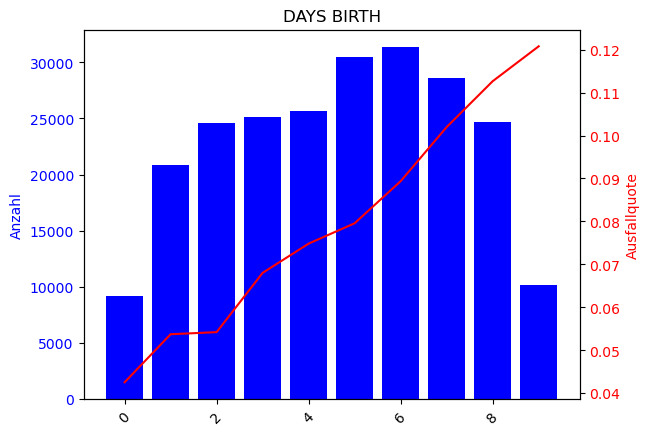

In [174]:
def univariate_graph(data, var, **kwargs):
    '''
    This function takes at least a dataset and a variable name of the dataset. The variable name should be the feature you are looking at.
    It then groups by the variable values and calculates the amount of observations in the variable's categories and the percentage of 
    defaults in each category. If your variable is not categorical, it takes on an extra argument, n_bins, to make it categorical.
    The outcome of the variable is a plot that shows the amount of observations in each bucket as bars and the share of defaults as a line.
    '''
    df = data.copy()
    if type(df[var][0]) == str:
        df = df.groupby(var).agg({
            'TARGET' : [np.mean, len], 
            })
    else:
        df[var] = KBinsDiscretizer(**kwargs, 
                                   encode = 'ordinal',
                                   strategy = 'uniform',
                                  ).fit_transform(df[[var]])
        df = df.groupby(var).agg({
            'TARGET' : [np.mean, len],
            })
        
#     make graph
    fig, ax1 = plt.subplots()
    ax1.set_title(var.replace('_', ' '))
#     bar plot
    ax1.tick_params(axis = 'x', 
                    rotation = 45,
                   )
    ax1.set_ylabel('Anzahl', 
                   color = 'blue',
                  )
    ax1.bar(list(df.index),
            list(df['TARGET']['len']),
            label = 'Anzahl',
            color = 'blue',
            )
    ax1.tick_params(axis = 'y', 
                    labelcolor = 'blue',
                   ) 
#     line graph
    ax2 = ax1.twinx() 
    ax2.set_ylabel('Ausfallquote', 
                   color = 'red',
                   ) 
    ax2.plot(df['TARGET']['mean'],
             label = 'Ausfallquote', 
             color = 'red',
             ) 
    ax2.tick_params(axis = 'y', 
                    labelcolor = 'red') 
#     save figure
    plt.savefig(var+'.png')
#     show plot
    plt.show() 
    
univariate_graph(X_train, 'DAYS_BIRTH', n_bins = 10)

# Model

In [25]:
log_reg = LogisticRegression()

log_reg.fit(X_train_processed_cleaned, y_train_processed_cleaned)

LogisticRegression()

### Evaluate

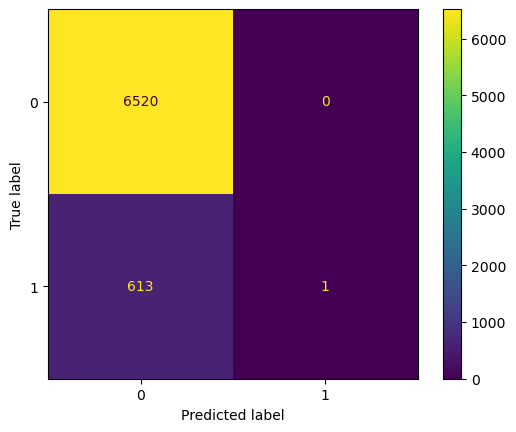

In [26]:
plot_confusion_matrix(log_reg, X_test_processed_cleaned, y_test_processed_cleaned)

In [27]:
print(classification_report(y_test_processed_cleaned, log_reg.predict(X_test_processed_cleaned)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96      6520
           1       1.00      0.00      0.00       614

    accuracy                           0.91      7134
   macro avg       0.96      0.50      0.48      7134
weighted avg       0.92      0.91      0.87      7134



## Kfold validation

In [28]:
accuracies = []
model = []

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

X = X_train.reset_index(drop = True)
y = y_train.reset_index(drop = True)

for train_fold, test_fold in kf.split(X_train):

    # split
    X_train_fold, X_test_fold = X.iloc[train_fold], X.iloc[test_fold]
    y_train_fold, y_test_fold = y[train_fold], y[test_fold]
    
    # transform
    X_train_fold_processed = pd.DataFrame(ct.fit_transform(X_train_fold))
    X_test_fold_processed = pd.DataFrame(ct.fit_transform(X_test_fold)) 
    y_train_fold_processed = y_train_fold.reset_index(drop=True)
    y_test_fold_processed = y_test_fold.reset_index(drop=True)
    
    # clean
    index_train = (X_train_fold_processed.isna().sum(axis=1)) | (y_train_fold_processed.isna())
    index_test = (X_test_fold_processed.isna().sum(axis=1)) | (y_test_fold_processed.isna())
    X_train_fold_processed_cleaned = X_train_fold_processed[-index_train]
    y_train_fold_processed_cleaned = y_train_fold_processed[-index_train]
    X_test_fold_processed_cleaned = X_test_fold_processed[-index_test]
    y_test_fold_processed_cleaned = y_test_fold_processed[-index_test]

    # model
    lr = LogisticRegression()
    lr.fit(X_train_fold_processed_cleaned, y_train_fold_processed_cleaned)

    # save
    model.append(lr)
    accuracies.append(accuracy_score(lr.predict(X_test_fold_processed_cleaned), y_test_fold_processed_cleaned))
